In [1]:
cd ../src

/Users/dani/Google Drive/Uni/Master/P4 2021/DD2424 - Deep Learning for Data Science/Project/ScarceClassifier/src


In [2]:
from d07_visualization.viz_training import plot_acc, plot_training_loss, plot_losses
from d04_mixmatch.wideresnet import WideResNet
from d02_data.load_data import get_dataloaders_ssl
import torch
import torch.nn as nn
import numpy as np

In [4]:
model_name = 'model_ema_10k.pt'
saved_model = torch.load(f'../models/saved_models/{model_name}', map_location=torch.device('cpu')) 

model = WideResNet(depth=28, k=2, n_out=10, bias=False)
model.load_state_dict(saved_model['model_state_dict'])
# ema_model = WideResNet(depth=28, k=2, n_out=10)
# ema_model.load_state_dict(saved_model['ema_state_dict'])

# optim = ...
# optim.load_state_dict(saved_model['optimizer_state_dict'])

loss_train = saved_model['loss_train']
loss_val = saved_model['loss_val']
acc_train = saved_model['acc_train']
acc_val = saved_model['acc_val']


In [53]:
model.state_dict().values()

odict_values([tensor([[[[-1.4159e-02,  8.3101e-02,  6.3980e-02],
          [-1.4060e-02, -1.2894e-01,  1.2220e-01],
          [ 4.0554e-02, -2.2513e-02,  3.6113e-02]],

         [[ 3.9349e-02, -3.2574e-01, -1.9321e-02],
          [-1.9257e-01, -6.7680e-02, -3.2238e-02],
          [ 2.3989e-03, -2.9206e-02,  8.8986e-02]],

         [[ 1.6258e-01,  5.6650e-02,  1.4484e-01],
          [-6.8564e-02, -7.9959e-04, -2.3396e-01],
          [-7.4447e-02, -2.2377e-01,  2.1155e-01]]],


        [[[ 1.5563e-01, -1.6422e-01, -3.4667e-04],
          [ 1.5736e-01,  4.5359e-02,  3.3618e-01],
          [-5.7521e-02,  9.9245e-03,  5.7112e-03]],

         [[ 4.7029e-02, -2.3735e-02,  1.6434e-01],
          [ 7.8068e-02,  2.6028e-02,  4.1002e-02],
          [-6.9179e-02,  3.3322e-02,  2.5343e-01]],

         [[-1.7769e-01, -4.3213e-02,  1.1831e-01],
          [-1.3960e-01, -1.8093e-01,  4.1101e-02],
          [-9.6349e-02, -9.2094e-02, -1.2803e-01]]],


        [[[-2.5988e-01, -1.7639e-01,  6.9809e-02],
 

In [54]:
ema_model.state_dict().values()

odict_values([tensor([[[[ 2.0285e-01, -1.5785e-01,  7.7537e-02],
          [-1.3958e-01,  1.1518e-01,  5.0956e-02],
          [-3.5552e-02, -1.2661e-01,  6.8739e-02]],

         [[ 1.4309e-01, -4.9496e-02,  8.4853e-03],
          [-1.3483e-01, -1.2212e-01, -2.2137e-02],
          [ 8.0047e-02, -3.4319e-03, -1.6074e-01]],

         [[ 1.4130e-01, -5.0114e-02,  1.2738e-01],
          [ 4.6718e-02,  8.2363e-03,  9.1680e-02],
          [-1.1682e-01, -1.5380e-01, -4.6664e-02]]],


        [[[ 1.1753e-01,  3.7276e-03,  4.8016e-02],
          [-8.5876e-02,  9.0673e-02, -1.3081e-01],
          [-9.7828e-02, -8.0147e-02,  1.5518e-01]],

         [[-6.8950e-02, -1.1681e-01, -1.1599e-01],
          [ 3.2535e-02,  1.5058e-01, -1.5110e-01],
          [-6.1193e-02,  8.3073e-02,  3.4841e-02]],

         [[ 7.0485e-02,  9.5808e-02, -1.2146e-01],
          [ 1.0964e-01,  8.4121e-03, -7.0737e-02],
          [-1.3802e-01, -1.1433e-01,  1.0146e-02]]],


        [[[ 5.0153e-02, -8.2255e-02,  5.5389e-02],
 

In [5]:
loss_batch = saved_model['loss_batch']
lx = saved_model['lx']
lu = saved_model['lu']
lu_weighted = saved_model['lu_weighted']

In [6]:
saved_model.keys()

dict_keys(['model_state_dict', 'ema_state_dict', 'optimizer_state_dict', 'loss_train', 'loss_val', 'acc_train', 'acc_val', 'loss_train_ema', 'loss_val_ema', 'acc_train_ema', 'acc_val_ema', 'loss_batch', 'lx', 'lu', 'lu_weighted', 'steps', 'batch_size', 'num_labels', 'lambda_u_max', 'step_top_up', 'lr', 'weight_decay', 'momentum', 'lr_decay'])

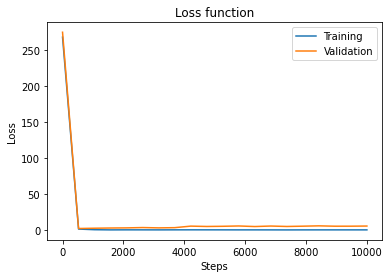

In [14]:
plot_training_loss(loss_train, loss_val, step=500)


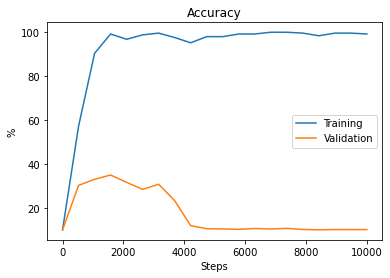

In [8]:
plot_acc(acc_train, acc_val, step=500)

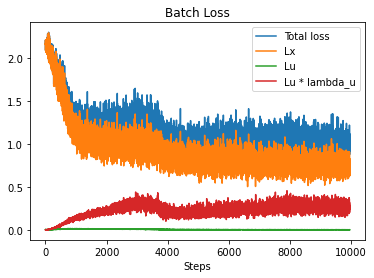

In [10]:
plot_losses(loss_batch[50:], lx[50:], lu[50:], lu_weighted[50:])

In [19]:
def evaluate(dataloader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    correct, total, loss = 0, 0, 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total * 100
    return loss, acc

_, _, _, test_loader = get_dataloaders_ssl(path='../data', batch_size=64, num_labeled=250)
test_val, test_acc = evaluate(test_loader)
print("Test accuracy: %.3f" % (test_acc))

Files already downloaded and verified
Files already downloaded and verified
Test accuracy: 35.220


In [11]:
loss_list = []
for i in range(10):
    loss_list.append(round(np.mean(lu[i*1000:(i+1)*1000]),3))
print(loss_list)

[0.01, 0.013, 0.011, 0.008, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004]
